In [1]:
!https_proxy=http://192.41.170.23:3128 http_proxy=http://192.41.170.23:3128 pip install bertviz

In [2]:
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from transformers import BertTokenizer
import numpy as np
from transformers import BertModel
from tqdm import tqdm 
from torch.utils.data import Dataset, DataLoader
import os
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [3]:
model_version = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_version)

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
class Inputexample(object):
    def __init__(self,text_a,label = None):
        self.text = text_a
        self.label = label
def load_examples(file_path, do_lower_case=True):
    examples = []
    
    with open('{}/seq.in'.format(file_path),'r',encoding="utf-8") as f_text, open('{}/label'.format(file_path),'r',encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            
            e = Inputexample(text.strip(),label=label.strip())
            examples.append(e)
            
    return examples

In [6]:
class CustomTextDataset(Dataset):
    def __init__(self,labels,text,batch_size,repeated_label:bool=False):
        self.labels = labels
        self.text = text
        self.batch_size = batch_size 
        self.count = 0 
        self.batch_labels = []
        self.repeated_label = repeated_label
        
        if self.repeated_label == True:
            print("Train on Combine between Supervised Contrastive and Cross Entropy loss")
            
        else:
            print("Train on Cross Entropy loss")
            
        
        print("len of dataset :",len(self.labels))
              
     
          

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        
        
        # write code here for 1)
        if self.repeated_label == True:
        
            if len(np.unique(self.batch_labels)) == self.batch_size - 1:


                while True:
                    idx = np.random.choice(len(self.labels))

                    if self.labels[idx]  in self.batch_labels:

                       
                        break

        self.batch_labels.append(self.labels[idx])
        
        label = self.labels[idx]
        
        data = self.text[idx]
        
        sample = {"Class": label,"Text": data}


    
        return sample

In [7]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 4 
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 

In [8]:
path_train = f'./bin/HWU64/train/'
path_5shot = f'./bin/HWU64/train_5/'
path_10shot = f'./bin/HWU64/train_10/'
valid_path = f'./bin/HWU64/valid/'
test_path = f'./bin/HWU64/test/'
path_train = load_examples(path_train)
path_10shot = load_examples(path_10shot)
path_5shot = load_examples(path_5shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)

df_train = []
labels_df_train = []
print("===== small path_train ====")

for i in range(len(path_train)):
    df_train.append(path_train[i].text)
    labels_df_train.append(path_train[i].label)


train_data = CustomTextDataset(labels_df_train,df_train,batch_size=batch_size,repeated_label=False)
# train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

df_train_shot = []
labels_df_train_shot = []
print("===== small path_train_shot ====")

for i in range(len(path_10shot)):
    df_train_shot.append(path_10shot[i].text)
    labels_df_train_shot.append(path_10shot[i].label)
    
for i in range(len(path_5shot)):
    df_train_shot.append(path_5shot[i].text)
    labels_df_train_shot.append(path_5shot[i].label)


train_shot_data = CustomTextDataset(labels_df_train_shot,df_train_shot,batch_size=batch_size,repeated_label=False)
# train_loader_ = DataLoader(train_shot_data,batch_size=batch_size,shuffle=True)





print("===== validation set ====")

df_valid = []
labels_valid = []

for i in range(len(valid_samples)):
    df_valid.append(valid_samples[i].text)
    labels_valid.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels_valid,df_valid,batch_size=batch_size,repeated_label=False)
# valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)



print("===== test set ====")

df_test = []
labels_test = []
    
for i in range(len(test_samples)):
    df_test.append(test_samples[i].text)
    labels_test.append(test_samples[i].label)

test_data = CustomTextDataset(labels_test,df_test,batch_size=batch_size,repeated_label=False)
# test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels_df_train_shot)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels_df_train_shot))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== small path_train ====
Train on Cross Entropy loss
len of dataset : 8954
===== small path_train_shot ====
Train on Cross Entropy loss
len of dataset : 960
===== validation set ====
Train on Cross Entropy loss
len of dataset : 1076
===== test set ====
Train on Cross Entropy loss
len of dataset : 1076


In [9]:
labels = {unique_label[i]: i for i in range(len(unique_label))}
# labels

In [10]:
df_train = pd.DataFrame(list(zip(df_train ,labels_df_train)),
               columns =['sentences', 'category'])
# df_train['category'] = df_train['intent'].map(label_maps)
df_train = df_train.sample(frac = 1)
df_train.reset_index(inplace = True)
del df_train['index']
df_train= df_train.iloc[0:1000]
df_train['labels']  = df_train['category'].map(label_maps)
df_train

,sentences,category,labels
0,olly can you shut up please.,general_commandstop,17
1,do the knicks have a game at home tonight,calendar_query,6
2,"nope, it's not the correct command.",general_negate,22
3,play the serial podcast,play_podcasts,45
4,lower the lights a little more,iot_hue_lightdim,29
...,...,...,...
995,play the book which i heard on some particular...,play_audiobook,42
996,move to the next song in the list,music_settings,40
997,show contact of john,email_querycontact,14
998,how can i make your day a little better,general_quirky,24


In [11]:
df_train_shot = pd.DataFrame(list(zip(df_train_shot,labels_df_train_shot)),
               columns =['sentences', 'category'])
df_train_shot['labels'] = df_train_shot['category'].map(label_maps)
df_train_shot

,sentences,category,labels
0,remind me about my alarms today,alarm_query,0
1,list my different alarm,alarm_query,0
2,what alarms are set,alarm_query,0
3,list alarms,alarm_query,0
4,what's the alarm situation for tomorrow,alarm_query,0
...,...,...,...
955,weather forecast please,weather_query,63
956,is it sunny in gonbad now,weather_query,63
957,what's the temperature,weather_query,63
958,what is today's weather in springfield,weather_query,63


In [12]:
result = pd.concat([df_train,df_train_shot])

In [13]:
result.reset_index(inplace = True)
del result['index']
df_train = result
df_train

,sentences,category,labels
0,olly can you shut up please.,general_commandstop,17
1,do the knicks have a game at home tonight,calendar_query,6
2,"nope, it's not the correct command.",general_negate,22
3,play the serial podcast,play_podcasts,45
4,lower the lights a little more,iot_hue_lightdim,29
...,...,...,...
1955,weather forecast please,weather_query,63
1956,is it sunny in gonbad now,weather_query,63
1957,what's the temperature,weather_query,63
1958,what is today's weather in springfield,weather_query,63


In [14]:
df_valid = pd.DataFrame(list(zip(df_valid,labels_valid)),
               columns =['sentences', 'category'])
df_valid['labels'] = df_valid['category'].map(label_maps)
df_valid

,sentences,category,labels
0,do i have alarms set before six in the morning,alarm_query,0
1,what alarms do i all have set,alarm_query,0
2,can you tell me about the alarm called bed,alarm_query,0
3,olly find any alarms i have set for today,alarm_query,0
4,what alarms are upcoming,alarm_query,0
...,...,...,...
1071,do i need a rain coat today,weather_query,63
1072,weather in chicago please,weather_query,63
1073,what is the weather going to be like on march ...,weather_query,63
1074,how is the weather down in orange tx,weather_query,63


In [15]:
df_test = pd.DataFrame(list(zip(df_test,labels_test )),
               columns =['sentences', 'category'])
df_test['labels'] = df_test['category'].map(label_maps)
df_test

,sentences,category,labels
0,tell me time of alarm you set,alarm_query,0
1,list all of my alarms,alarm_query,0
2,alarm settings,alarm_query,0
3,what alarms are set for today,alarm_query,0
4,please see see for me the alarms that you have...,alarm_query,0
...,...,...,...
1071,what is the climate here today,weather_query,63
1072,let me know when the next cold front is expected,weather_query,63
1073,i am gonna need an umbrella today after sunset,weather_query,63
1074,google what is the temperature outside,weather_query,63


In [16]:
print("Train data",df_train.shape)
print("Validate data",df_valid.shape)
print("Test data",df_test.shape)

Train data (1960, 3)
Validate data (1076, 3)
Test data (1076, 3)


In [17]:
# df_test.loc[df.label == 0].sample(5)[['sentences', 'labels']]

In [18]:
# Get the lists of sentences and their labels.
sentences_train = df_train.sentences.values
labels_train = df_train.labels.values

In [19]:
sentences_valid = df_valid.sentences.values
labels_valid = df_valid.labels.values

In [20]:
sentences_test = df_test.sentences.values
labels_test = df_test.labels.values

In [21]:
# Print the original sentence.
print(' Original: ', sentences_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  olly can you shut up please.
Tokenized:  ['ol', '##ly', 'can', 'you', 'shut', 'up', 'please', '.']
Token IDs:  [19330, 2135, 2064, 2017, 3844, 2039, 3531, 1012]


In [22]:
max_len = 0

# For every sentence...
for sent in sentences_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentences_train length: ', max_len)

Max sentences_train length:  23


In [23]:
input_ids_train = []
attention_masks_train = []

# For every sentence...
for sent in sentences_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_train[0])
print('Token IDs:', input_ids_train[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  olly can you shut up please.
Token IDs: tensor([  101, 19330,  2135,  2064,  2017,  3844,  2039,  3531,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

In [24]:
input_ids_valid = []
attention_masks_valid = []

# For every sentence...
for sent in sentences_valid:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_valid.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_valid.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_valid = torch.cat(input_ids_valid, dim=0)
attention_masks_valid = torch.cat(attention_masks_valid, dim=0)
labels_valid = torch.tensor(labels_valid)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_valid[0])
print('Token IDs:', input_ids_valid[0])

Original:  do i have alarms set before six in the morning
Token IDs: tensor([  101,  2079,  1045,  2031, 29034,  2275,  2077,  2416,  1999,  1996,
         2851,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,   

In [25]:
labels

{'alarm_query': 0,
 'alarm_remove': 1,
 'alarm_set': 2,
 'audio_volume_down': 3,
 'audio_volume_mute': 4,
 'audio_volume_up': 5,
 'calendar_query': 6,
 'calendar_remove': 7,
 'calendar_set': 8,
 'cooking_recipe': 9,
 'datetime_convert': 10,
 'datetime_query': 11,
 'email_addcontact': 12,
 'email_query': 13,
 'email_querycontact': 14,
 'email_sendemail': 15,
 'general_affirm': 16,
 'general_commandstop': 17,
 'general_confirm': 18,
 'general_dontcare': 19,
 'general_explain': 20,
 'general_joke': 21,
 'general_negate': 22,
 'general_praise': 23,
 'general_quirky': 24,
 'general_repeat': 25,
 'iot_cleaning': 26,
 'iot_coffee': 27,
 'iot_hue_lightchange': 28,
 'iot_hue_lightdim': 29,
 'iot_hue_lightoff': 30,
 'iot_hue_lighton': 31,
 'iot_hue_lightup': 32,
 'iot_wemo_off': 33,
 'iot_wemo_on': 34,
 'lists_createoradd': 35,
 'lists_query': 36,
 'lists_remove': 37,
 'music_likeness': 38,
 'music_query': 39,
 'music_settings': 40,
 'news_query': 41,
 'play_audiobook': 42,
 'play_game': 43,
 'p

In [26]:
from torch.utils.data import TensorDataset, random_split
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)

In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [28]:
# for step, batch in enumerate(train_loader):
#     print(step, batch)
#     break

In [29]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 64, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [31]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [32]:
from transformers import get_linear_schedule_with_warmup

epochs = 20

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [33]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [34]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [35]:
# for step, batch in enumerate(train_loader):
#     print(step, batch)
#     break

In [36]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_loader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_loader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_loader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:11.

  Average training loss: 4.06
  Training epcoh took: 0:00:16

Running Validation...
  Accuracy: 0.10
  Validation Loss: 3.85
  Validation took: 0:00:03

======== Epoch 2 / 20 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:11.

  Average training loss: 3.59
  Training epcoh took: 0:00:16

Running Validation...
  Accuracy: 0.32
  Validation Loss: 3.34
  Validation took: 0:00:03

======== Epoch 3 / 20 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:11.

  Average training loss: 3.08
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.52
  Validation Loss: 2.84
  Validation took: 0:00:03

======== Epoch 4 / 20 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:11.

  Average training loss: 2.57
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.66
  Validation Loss: 2.38
  Validation took: 0:00:03

======== Epoch 5 / 20 =

In [37]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,4.06,3.85,0.10,0:00:16,0:00:03
2,3.59,3.34,0.32,0:00:16,0:00:03
3,3.08,2.84,0.52,0:00:17,0:00:03
4,2.57,2.38,0.66,0:00:17,0:00:03
5,2.13,1.99,0.73,0:00:17,0:00:03
6,1.75,1.68,0.77,0:00:18,0:00:03
7,1.43,1.45,0.79,0:00:18,0:00:03
8,1.17,1.24,0.82,0:00:18,0:00:03
9,0.95,1.08,0.84,0:00:18,0:00:03


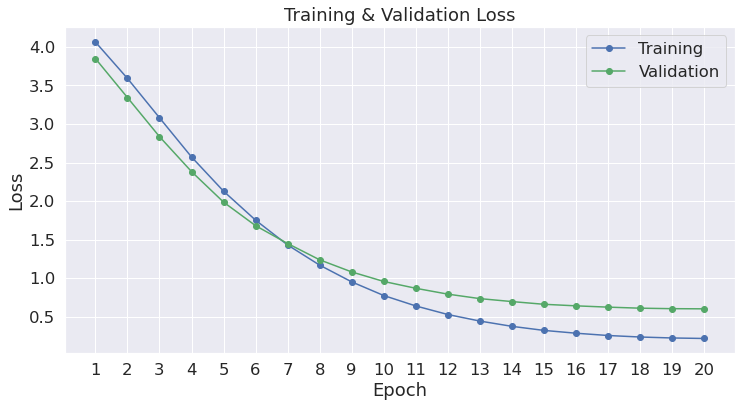

In [38]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plt.show()

In [39]:
inverse_labels = {v:k for k,v in labels.items()}
def test(model,test_df):
    total_acc = 0
    with torch.no_grad():
        for i in tqdm(range(len(df_test))):
        # print(df_test['sentences'][1])  
            sentence = df_test['sentences'][i]
            sentence_input = tokenizer(sentence, padding='max_length', max_length=512, truncation=True,return_tensors="pt").to(device)
            input_id = sentence_input["input_ids"].to(device)
            mask = sentence_input["attention_mask"]
            output = model(input_id,mask)[0]   
            # print(output)
            predicted_class_label = output.argmax(dim=1) 
            # print(predicted_class_label)
            predicted_class = inverse_labels[predicted_class_label.item()]
            # print(f"The predicted class is : {predicted_class}")
            acc = (predicted_class_label  == df_test['labels'][i]).sum().item()
            # print(acc)
            total_acc +=acc 
        print(f"Test Accuracy : {total_acc / len(test_df): .3f}")

In [40]:
test(model,test_df=df_test) #trained model

100%|██████████| 1076/1076 [00:19<00:00, 56.17it/s]

Test Accuracy :  0.875


In [41]:
import pandas as pd
# Create sentence and label lists
sentences_test = df_test.sentences.values
labels_test = df_test.labels.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
attention_masks_test = []

# For every sentence...
for sent in sentences_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [42]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 11 test sentences...
    DONE.


In [43]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


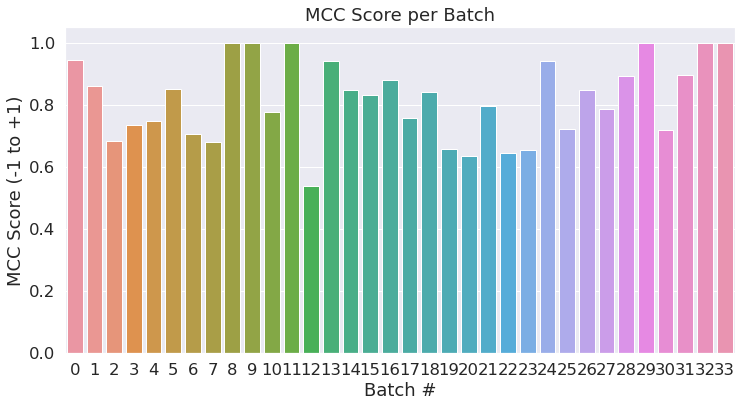

In [44]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [45]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.873


In [46]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_saveBanking77/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_saveBanking77/


('./model_saveBanking77/tokenizer_config.json',
 './model_saveBanking77/special_tokens_map.json',
 './model_saveBanking77/vocab.txt',
 './model_saveBanking77/added_tokens.json')

In [47]:
def predict(model,sentence):
    sentence = sentence
    sentence_input = tokenizer(sentence, padding='max_length', max_length=512, truncation=True,return_tensors="pt").to(device)
    input_id = sentence_input["input_ids"].to(device)
    mask = sentence_input["attention_mask"]
    output = model(input_id,mask)[0]   
    # print(output)
    predicted_class_label = output.argmax(dim=1) 
    # print(predicted_class_label)
    predicted_class = inverse_labels[predicted_class_label.item()]
    print(f"The predicted class is : {predicted_class}")

In [48]:
df_test

,sentences,category,labels
0,tell me time of alarm you set,alarm_query,0
1,list all of my alarms,alarm_query,0
2,alarm settings,alarm_query,0
3,what alarms are set for today,alarm_query,0
4,please see see for me the alarms that you have...,alarm_query,0
...,...,...,...
1071,what is the climate here today,weather_query,63
1072,let me know when the next cold front is expected,weather_query,63
1073,i am gonna need an umbrella today after sunset,weather_query,63
1074,google what is the temperature outside,weather_query,63


In [49]:
predict(model,df_test['sentences'][1075])

The predicted class is : weather_query


In [50]:
predict(model,df_test['sentences'][3079])

KeyError: 3079

In [ ]:
predict(model,"i think i have an extra transfer charge.")

In [ ]:
predict(model,"can the card be mailed and used in europe?")

In [ ]:
predict(model,df_test['sentences'][1])

In [ ]:
predict(model,df_test['sentences'][2])

In [ ]:
predict(model,df_test['sentences'][3])

In [ ]:
df_test['sentences'][1],df_test['sentences'][2]


In [ ]:
predict(model,"I forget pasword")

In [ ]:
predict(model,"Can you check if the card has arrived?")

In [ ]:
predict(model,df_test['sentences'][2])

In [51]:
inputs_test = tokenizer.encode_plus(df_test['sentences'][1], df_test['sentences'][2], return_tensors='pt')
input_ids = inputs_test['input_ids'].to(device)
token_type_ids = inputs_test['token_type_ids'].to(device)
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 
sentence_b_start = token_type_ids[0].tolist().index(1)
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [52]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [ ]:
df_test['sentences'][2]

In [ ]:
inputs_test = tokenizer.encode_plus(df_test['sentences'][2], df_test['sentences'][3], return_tensors='pt')
input_ids = inputs_test['input_ids'].to(device)
token_type_ids = inputs_test['token_type_ids'].to(device)
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 
sentence_b_start = token_type_ids[0].tolist().index(1)
head_view(attention, tokens, sentence_b_start)

In [ ]:
model_view(attention, tokens, sentence_b_start)

In [ ]:
df_test['sentences'][3]

In [ ]:
inputs_test = tokenizer.encode_plus(df_test['sentences'][3], df_test['sentences'][4], return_tensors='pt')
input_ids = inputs_test['input_ids'].to(device)
token_type_ids = inputs_test['token_type_ids'].to(device)
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 
sentence_b_start = token_type_ids[0].tolist().index(1)
head_view(attention, tokens, sentence_b_start)

In [ ]:
model_view(attention, tokens, sentence_b_start)